Load dependencies

In [29]:
import scanpy as sc
import anndata as ad
import pandas as pd

Set settings and constants

In [30]:
sc.settings.set_figure_params(dpi=50, facecolor="white")
DATA_DIR = '/data/BIOL5177/Assessment'
SAMPLES = ['Infected1','Infected2','WT1']

Load in the data

In [113]:
# Returns an AnnData object which
def load_count_data_csv(data_dir, samples, counts_matrix = 'counts_matrix.csv', metadata = 'metadata.csv'):
    adata_dict = {}
    for sample_id in samples:
        print(sample_id)
        filepath = f'{data_dir}/{sample_id}/{counts_matrix}'
        a_filepath = f'{DATA_DIR}/WT1/{metadata}'
        counts_adata = sc.read(filepath)
        counts_adata = counts_adata.transpose()
        counts_adata.var_names_make_unique()
        
        #anno = pd.read_csv(a_filepath)
        #counts_adata.obs['nCount_RNA'] = anno['nCount_RNA']
        #counts_adata.obs['nFeature_RNA'] = anno['nFeature_RNA']
        #sample_adata.obs_names_make_unique()
        adata_dict[sample_id] = counts_adata
    
    adata = ad.concat(adata_dict, label="sample")
    #adata.obs_names_make_unique()
    
    return adata
    
    #return adata_dict

adata = load_count_data_csv(DATA_DIR, SAMPLES)


Infected1
Infected2
WT1


In [128]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"], inplace=True, log1p=True)

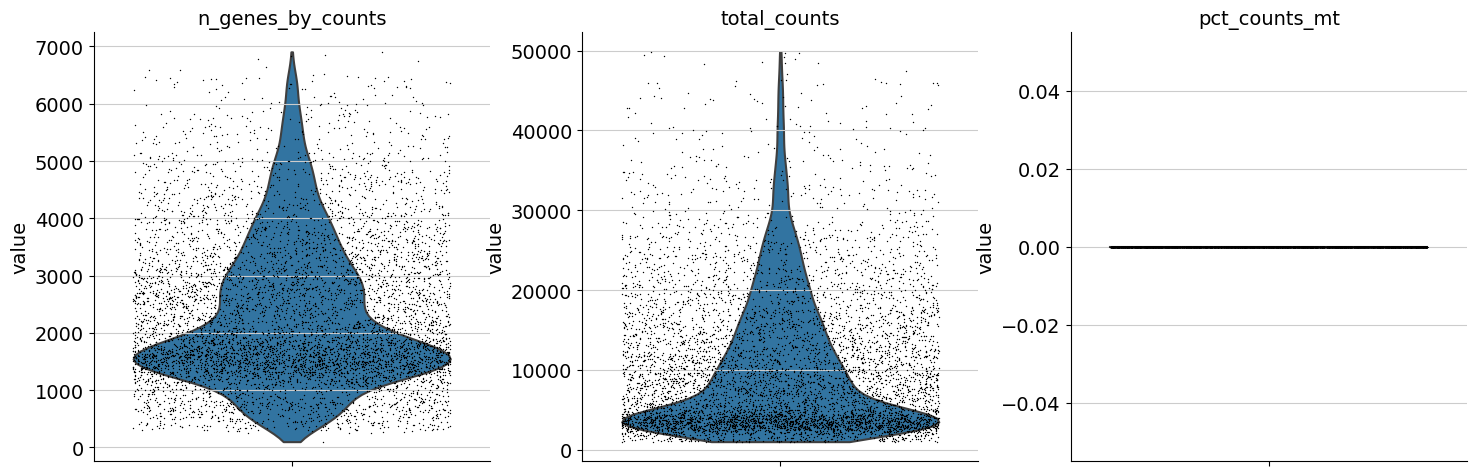

In [129]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [11]:
adata_1 = adata

In [13]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

NameError: name 'pooch' is not defined

In [88]:

#print(adata.obs["sample"].value_counts())
#print(adata)
#print(adata.var['mt'])
#pbmc = sc.datasets.pbmc3k()
#print(pbmc)
#print(pbmc.var)
#adata_1.obs
adata.var
#pbmc.var["mt"] = pbmc.var_names.str.startswith("MT-")
#pbmc.var

,mt


In [125]:
counts_matrix = 'counts_matrix.csv'
metadata = 'metadata.csv'
c_filepath = f'{DATA_DIR}/WT1/{counts_matrix}'
a_filepath = f'{DATA_DIR}/WT1/{metadata}'
#counts = pd.read_csv(c_filepath)
#anno = pd.read_csv(a_filepath)
#counts_adata = sc.read_csv(filepath)
#counts_adata.var
#anno
#adata_1 = sc.read(f'{DATA_DIR}/WT1/{counts_matrix}')
#counts
#adata_1['Mrpl15']
#adata_1.var["mt"] = adata.var_names.str.startswith("Mt-")
#sc.pp.calculate_qc_metrics(adata_1, qc_vars=["mt"], inplace=True, log1p=True)
#adata_1.obs
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AATAGAGCAGGAGACT_4,Infected1,5339,8.582981,32115.0,10.377110,24.583528,36.456485,47.921532,61.746847
TTCCGGTCACAGAAGC_4,Infected1,4996,8.516593,24284.0,10.097614,23.459891,34.619503,45.326141,59.351837
GGGTCACAGTTAGTAG_4,Infected1,4837,8.484257,26603.0,10.188817,25.245273,37.642371,48.464459,62.312521
ATGGAGGTCGACCAAT_4,Infected1,2843,7.952967,19089.0,9.856920,63.162030,67.871549,73.544974,81.801037
TTCCTAACACGCTGCA_4,Infected1,2471,7.812783,13837.0,9.535173,56.457325,61.993207,68.844403,79.330780
...,...,...,...,...,...,...,...,...,...
CGCATAACAGGCTATT_6,WT1,1633,7.398786,3617.0,8.193677,30.467238,40.088471,50.207354,68.122754
GGAGGATGTAGTGTGG_6,WT1,1491,7.307873,3349.0,8.116715,27.948641,39.235593,51.209316,70.409077
TCCGATCTCATTTCGT_6,WT1,1521,7.327781,3131.0,8.049427,27.147876,36.889173,48.323219,67.390610
TGTGTGAGTCCTGGGT_6,WT1,3209,8.074026,8843.0,9.087495,25.376004,36.661766,45.606695,58.939274
